In [1]:
# %% [code] {"jupyter":{"outputs_hidden":false}}

%reset -f

import gc

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# check the tensorflow and GPU
print(f"Using Tensorflow {tf.__version__}")
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print(
    f"Found GPU adn CPU.\nTensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)


# import the datasets and check the files

import os

# path = "./phys591000-2023-final-project/"  # run on the local machine
# path = "/content/drive/Shareddrives/2023AI_final/2023AI_final/phys591000-2023-final-project/" # run on the google colab
path = "/kaggle/input/dune-neutrino/"  # Kaggle
if not os.path.isfile(path + "neutrino_test_data.npz") or os.path.isfile(
    path + "neutrino_train_data.npz"
):
    raise FileNotFoundError("test/train data was not found or is a directory")

# take out data from the datasets

data_train = np.load(path + "neutrino_training_data.npz")  # ideal data
data_test = np.load(path + "neutrino_test_data.npz")  # pseudo-exp data

name_train = data_train.files
name_test = data_test.files

(
    ve_train,
    vebar_train,
    vu_train,
    vubar_train,
    theta23_train,
    delta_train,
    ldm_train,
) = map(lambda n: data_train[n], name_train)
ve_test, vebar_test, vu_test, vubar_test = map(lambda n: data_test[n], name_test)


# create train and test data
noise_ve    = 10 * np.random.normal(0, 1, size=ve_train.shape)
noise_vebar = 3 * np.random.normal(0, 1, size=vebar_train.shape)
noise_vu    = 30 * np.random.normal(0, 1, size=vu_train.shape)
noise_vubar = 20 * np.random.normal(0, 1, size=vubar_train.shape)

X_train_raw = np.stack((ve_train, vebar_train, vu_train, vubar_train), axis=-1)
X_train = np.stack((ve_train+noise_ve, vebar_train+noise_vebar, vu_train+noise_vu, vubar_train+noise_vubar), axis=-1)
Y_train = np.stack((theta23_train, delta_train, ldm_train), axis=-1)
X_test = np.stack((ve_test, vebar_test, vu_test, vubar_test), axis=-1)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Using Tensorflow 2.12.0
Found GPU adn CPU.
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# [X] normalize training data to [0,1]
x_train_NH = X_train[ldm_train > 0]
x_train_raw_NH = X_train_raw[ldm_train > 0]
print(f"Before normalized, the shape of x_train: {x_train_NH.shape}")
v_max = np.max(x_train_NH)
v_min = np.min(x_train_NH)
print(f"X-train normalized factors (v_max, v_min) = ({v_max}, {v_min})")
x_train_NH_norm = (x_train_NH - v_min) / (v_max - v_min)
x_train_raw_NH_norm = (x_train_raw_NH - v_min) / (v_max - v_min)
print(f"After normalized, the shape of x_train: {x_train_NH_norm.shape}")

# [X] normalize test data to [0,1]
x_test_NH = X_test
x_test_NH_norm = (x_test_NH - v_min) / (v_max - v_min)
print(f"After normalized, the shape of x_test: {x_test_NH_norm.shape}")

# [Y] normalize training label to [0,1]
y_train_NH = Y_train[:, 0][ldm_train > 0]
print(f"Before normalized, the shape of y_train: {y_train_NH.shape}")
v_max = np.max(y_train_NH)
v_min = np.min(y_train_NH)
y_train_NH_norm = (y_train_NH - v_min) / (v_max - v_min)
print(f"Y-train normalized factors (v_max, v_min) = ({v_max}, {v_min})")
print(f"After normalized, the shape of y_train: {y_train_NH_norm.shape}")

# clear unused variables
del (
    X_train,
    X_train_raw,
    Y_train,
    ve_train,
    vebar_train,
    vu_train,
    vubar_train,
    theta23_train,
    delta_train,
    ldm_train,
    ve_test,
    vebar_test,
    vu_test,
    vubar_test,
)
gc.collect()

Before normalized, the shape of x_train: (500027, 65, 4)
X-train normalized factors (v_max, v_min) = (2054.8696656833363, -66.27077250808408)
After normalized, the shape of x_train: (500027, 65, 4)
After normalized, the shape of x_test: (1000, 65, 4)
Before normalized, the shape of y_train: (500027,)
Y-train normalized factors (v_max, v_min) = (51.1, 38.9)
After normalized, the shape of y_train: (500027,)


0

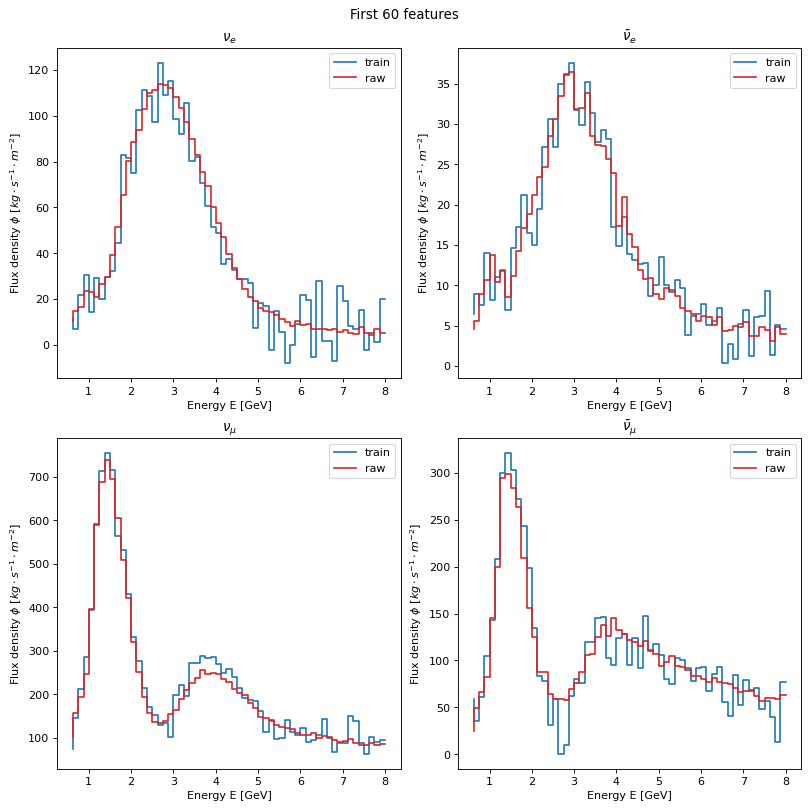

Success to plot


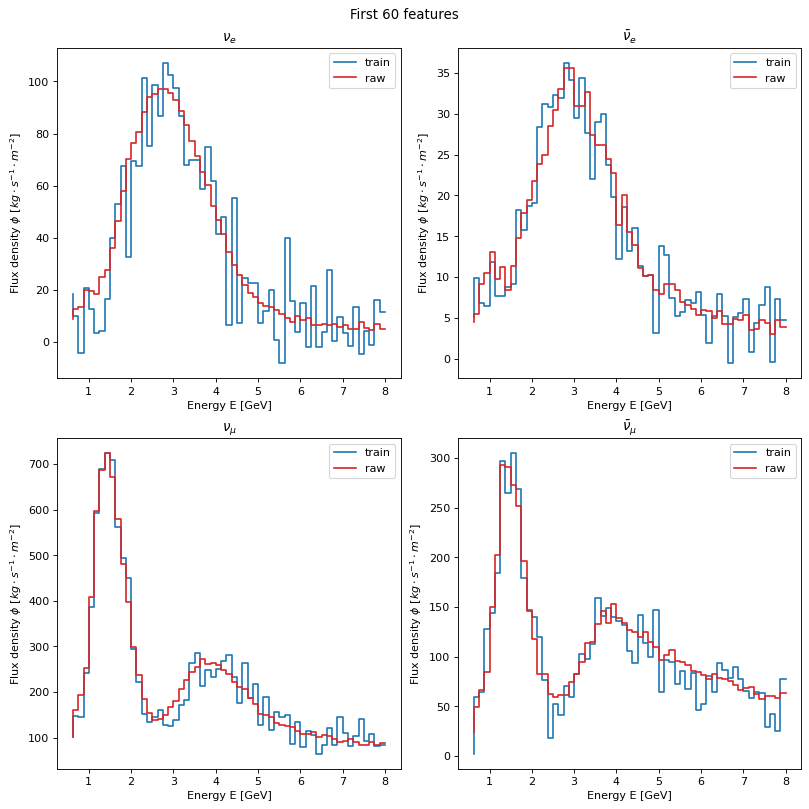

Success to plot


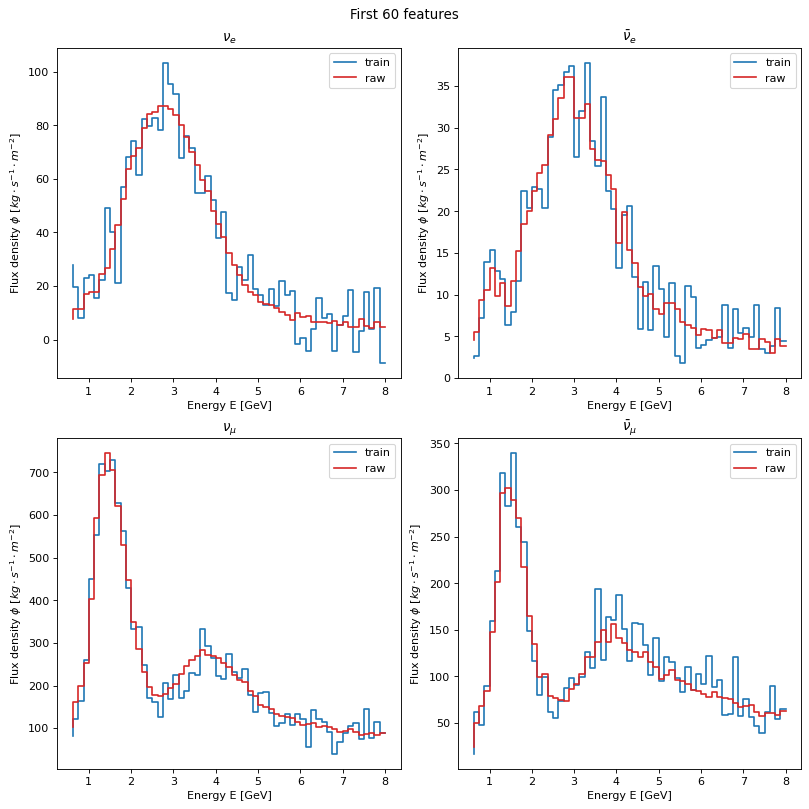

Success to plot


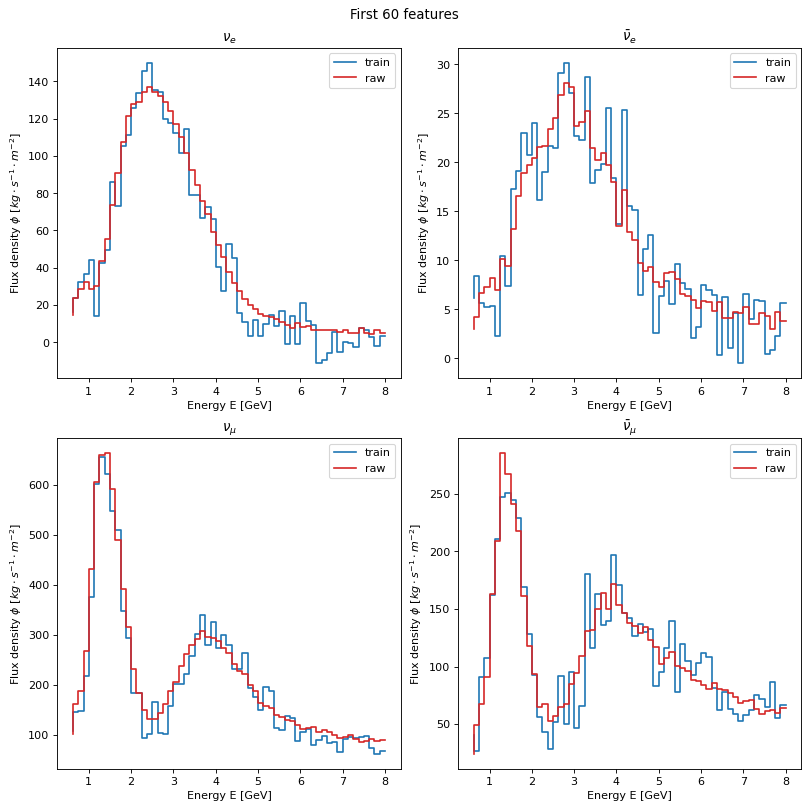

Success to plot


In [3]:
def four_plot(data_format: list) -> None:
    train, train_raw, test = data_format
    bins = np.arange(0.625, 8 + 0.125, 0.125)
    name = [r"$\nu_e$", r"$\bar{\nu}_e$", r"$\nu_\mu$", r"$\bar{\nu}_\mu$"]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=80, constrained_layout=True)
    fig.suptitle("First 60 features")
    for i, (train_data, raw_data, test_data, name) in enumerate(zip(train, train_raw, test, name)):
        ax = axes[i // 2, i % 2]
        ax.set_title(name)
        ax.step(bins, train_data[:60], label="train", color="tab:blue")
        ax.step(bins, raw_data[:60], label="raw", color="tab:red")
#         ax.step(bins, test_data[:60], label="test", color="grey")
        ax.legend(loc="best")
        ax.set_xlabel("Energy E [GeV]")
        ax.set_ylabel(r"Flux density $\phi\ [kg\cdot s^{-1}\cdot m^{-2}]$")

    plt.show()
    print("Success to plot")
    plt.close()
    return

# train_avg = [np.average(x_train_NH_norm[120:150][:,:,i], axis=0) for i in range(4)]
# test_avg = [np.average(x_test_NH_norm[120:150][:,:,i], axis=0) for i in range(4)]
# data_format = [train_avg, test_avg]
# four_plot(data_format)

for n in [15, 50, 55, 150]:
    train_10 = [x_train_NH[n,:,i] for i in range(4)]
    raw_10   = [x_train_raw_NH[n,:,i] for i in range(4)]
    test_10  = [x_test_NH[n,:,i] for i in range(4)]
    data_format = [train_10, raw_10, test_10]
    four_plot(data_format)

In [4]:
# create validation data
from sklearn.model_selection import train_test_split

# split the training dataset into training and validation, with test_size = 0.2
tf.random.set_seed(2023)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_NH_norm,
    y_train_NH_norm,
    random_state=10,
    test_size=0.2,
    shuffle=True,
)

# clear unused variables
del x_train_NH_norm, y_train_NH_norm

Model: "dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65, 4, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 33, 2, 64)         1088      
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 1, 64)         65600     
                                                                 
 re_lu (ReLU)                (None, 17, 1, 64)         0         
                                                                 
 batch_normalization (BatchN  (None, 17, 1, 64)        256       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 9, 1, 64)         0         
 ooling2D)                                                    

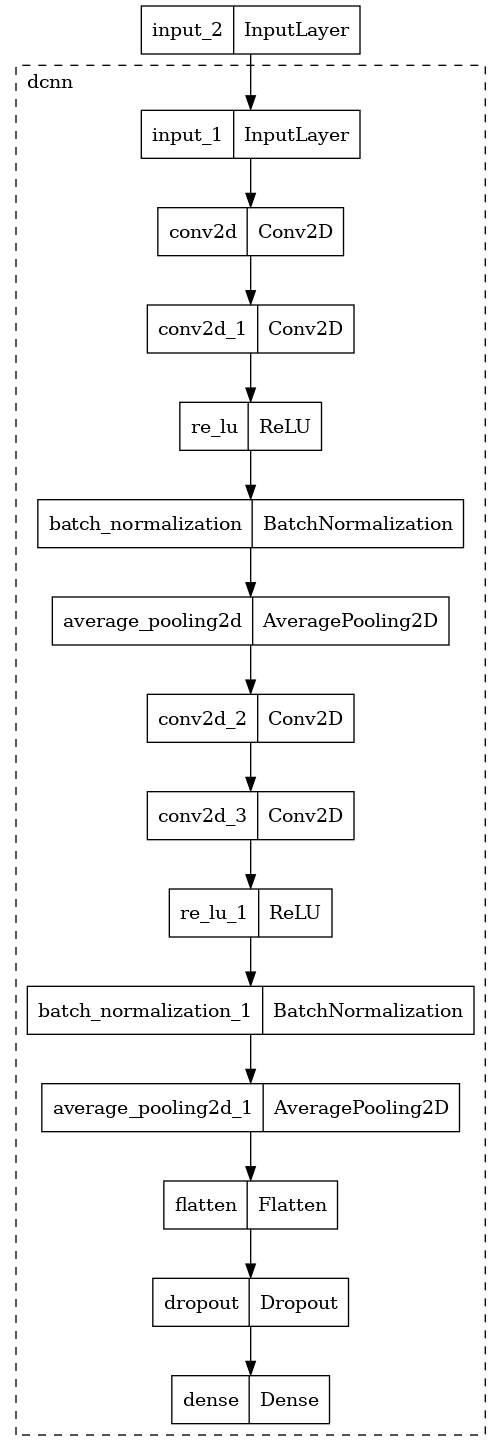

In [5]:
from tensorflow.keras import Input, Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    AveragePooling2D,
    MaxPooling2D,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Layer,
    LeakyReLU,
    ReLU,
    Reshape,
)
from keras.utils import plot_model


def create_model_cvae(input_dim):
    inputs = Input(shape=input_dim)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same", activation="relu")(inputs)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(padding="same")(x)
    x = Conv2D(32, kernel_size=4, strides=2, padding="same", activation="relu")(x)
    x = Conv2D(32, kernel_size=4, strides=2, padding="same")(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(padding="same")(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
#     x = ReLU()(x)
#     x = BatchNormalization()(x)
    dcnn = Model(inputs, x, name="dcnn")
    dcnn.summary()

    # create model
    model_inputs = Input(shape=input_dim)
    fin_dnn = dcnn(model_inputs)
    dcnn = Model(inputs=model_inputs, outputs=fin_dnn)
    return dcnn


from tensorflow.keras.optimizers import Adam

# Declare the model
dcnn = create_model_cvae(
    input_dim=(x_train.shape[1], x_train.shape[2], 1)
)

# Compile the model
dcnn.compile(optimizer=Adam(3e-5), loss="huber")

from tensorflow.keras.callbacks import EarlyStopping

# train
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

dcnn.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    epochs=512,
    batch_size=96,
    callbacks=[early_stopping],
    shuffle=True,
    verbose=2,
)
plot_model(dcnn, to_file='dcnn_model.png', expand_nested=True)

3126/3126 [==============================] - 6s 2ms/step


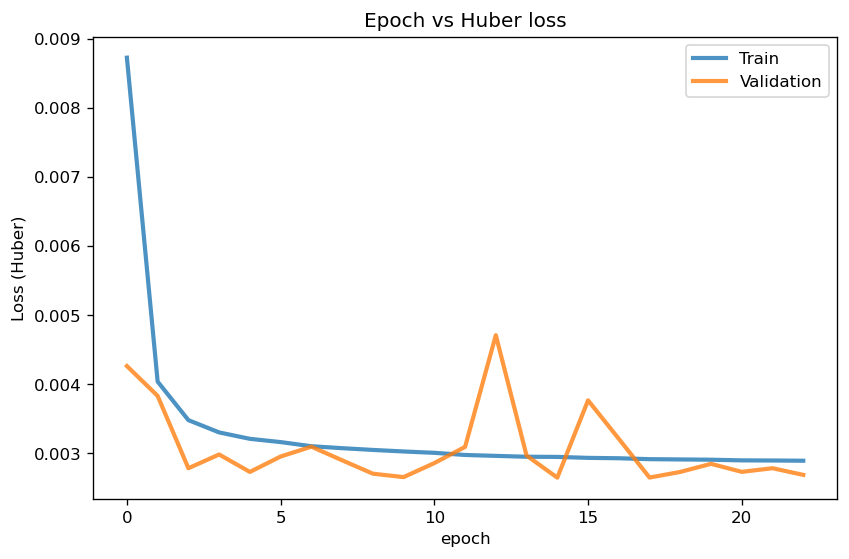

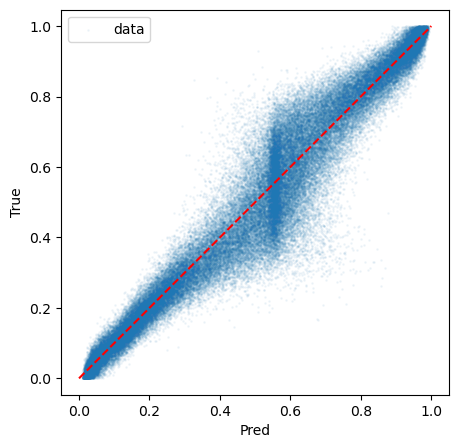

In [6]:
# check the loss function
fig = plt.figure(figsize=(8, 5), dpi=120)
history = dcnn.history.history
plt.plot(history["loss"], lw=2.5, label="Train", alpha=0.8)
plt.plot(history["val_loss"], lw=2.5, label="Validation", alpha=0.8)
# plt.semilogy()
plt.title("Epoch vs Huber loss")
plt.xlabel("epoch")
plt.ylabel("Loss (Huber)")
plt.legend(loc="best")
plt.savefig("DCNN.png")
# plt.close()

# check true-pred
fig = plt.figure(figsize=(5,5))
x_val_pred = dcnn.predict(x_val)
plt.scatter(x_val_pred, y_val, s=1, alpha=0.05, label="data")
plt.plot([0,1], [0,1], 'r--')
plt.legend(loc="best")
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("Pred")
plt.ylabel("True")
plt.axis('equal')
plt.savefig("dcnn_ratio.png")
# plt.close()

# save model
dcnn.save("./DCNN.h5")